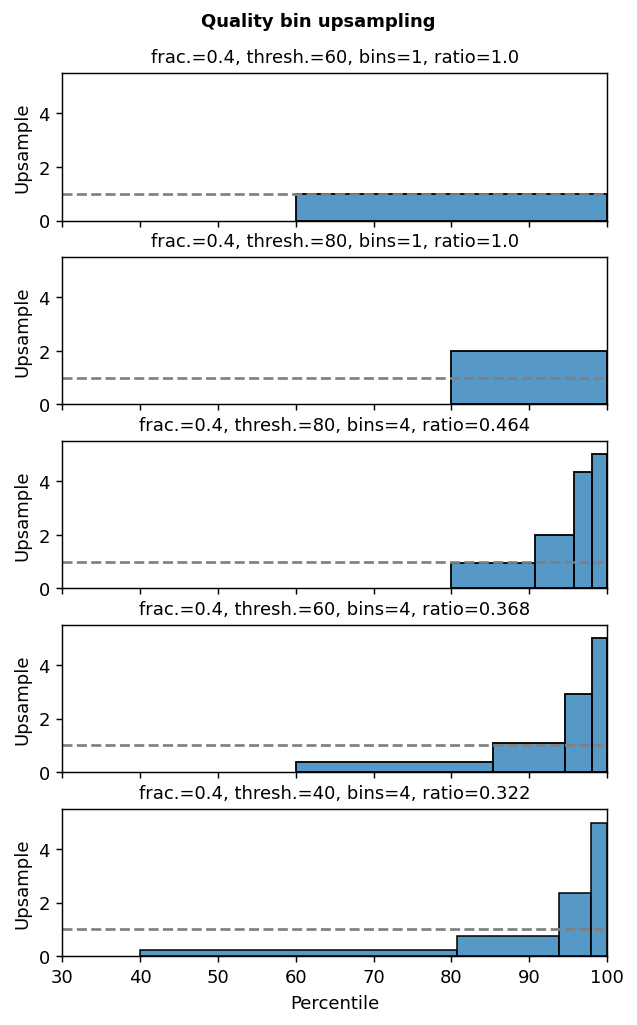

In [9]:
#!/usr/bin/env python3

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from glob import glob
import pandas as pd
import os
from pathlib import Path

def calculate_bin_boundaries(threshold, num_bins, ratio):
    """Calculate bin boundaries based on threshold, number of bins, and ratio."""
    if ratio != 1.0:
        bin_sum = 1 / (1 - ratio)
    else:
        bin_sum = num_bins

    # The first width in the series
    first_width = (100 - threshold) / bin_sum
    
    percentiles = [threshold]
    
    for i in range(0, num_bins - 1):
        width = first_width * (ratio**i)
        percentiles.append(percentiles[-1] + width)
    
    return percentiles

def calculate_upsamples(percentiles, sampling_fraction):
    """Calculate upsample factors for each bin."""
    percentage_bins = list(zip(percentiles, percentiles[1:] + [100]))
    bin_widths = [(percentage_bins[i][1] - percentage_bins[i][0]) / 100 for i in range(len(percentage_bins))]
    
    # Calculate bin upsamples to ensure equal area per bin
    num_bins = len(bin_widths)
    bin_upsamples = [sampling_fraction / num_bins / bin_widths[i] for i in range(num_bins)]
    
    return bin_upsamples

def plot_upsampling_distribution(params):
    plt.figure(figsize=(5, 8), dpi=130)
    for i, param in enumerate(params):
        sampling_fraction, threshold, num_bins, ratio = param
        """Plot the upsampling distribution."""
        # Calculate bin boundaries and upsamples
        percentages = calculate_bin_boundaries(threshold, num_bins, ratio)
        bin_upsamples = calculate_upsamples(percentages, sampling_fraction)
        percentages += [100]
        percentages = np.array(percentages, dtype=np.float64)
        bin_upsamples = np.array(bin_upsamples, dtype=np.float64)

        plt.subplot(len(params), 1, i + 1)
        sns.histplot(x=(percentages[:-1] + percentages[1:]) / 2, weights=bin_upsamples, bins=percentages.tolist(), stat="count")
        # add a line at 1
        plt.axhline(y=1, color='grey', linestyle='--')
        if i == len(params) - 1:
            plt.xlabel("Percentile", fontsize=10)
        else:
            plt.xlabel("")
            # show ticks but no labels
            plt.tick_params(labelbottom=False)
        plt.ylabel("Upsample", fontsize=10)
        plt.title(f"frac.={sampling_fraction}, thresh.={threshold}, bins={num_bins}, ratio={ratio}", fontsize=10)
        plt.ylim(0, 5.5)
        plt.xlim(30, 100)
    plt.suptitle("Quality bin upsampling", fontsize=10, fontweight="bold")
    plt.tight_layout(h_pad=0.05)
    plt.show()



def parse_config_filename(filename):
    """Parse config filename to extract f-t-r-b values."""
    parts = filename.split('-')
    f = float(parts[-4].split('f')[1])
    t = int(parts[-3].split('t')[1])
    b = int(parts[-2].split('b')[1])
    r = float(parts[-1].split('r')[1])
    return f, t, b, r

params = []
for p in Path("../configs").glob("aw_mix*_f0.4*t*b*r*.yaml"):
    f, t, b, r = parse_config_filename(p.stem)
    params.append((f, t, b, r))

plot_upsampling_distribution(
    params
)